# Matrix results analysis

For each place, plot 

In [167]:
import numpy as np
import pickle
import json
import os

import osmnx as ox

from tqdm import tqdm
import matplotlib.pyplot as plt

from data import get_data
from random_walks import get_end_nodes

In [105]:
with open("./places.json") as fin:
    places = json.load(fin)

## Compress edges

For every node, consider starting there as the starting point. We can travel to any of the neighbors with equal probability; take an average and add distance.

In [136]:
def save_average_time(slug, overwrite=False):
    """
    Take the data from solve_matrix.py and average
        results across nodes, not edges.
    """
    save_path = f"./output/avg_time/{slug}.pkl"
    if not overwrite and os.path.exists(save_path):
        print(f"  File {save_path} already exists. Skipping...")
        return

    with open(f"./output/matrix_method/{slug}.pkl", "rb") as fin:
        results = pickle.load(fin)
        
    E_time_edge, states = results["expected_time"], results["states"]
    state2idx = {state: idx for idx, state in enumerate(states)}

    G, adj, boba_gdf = get_data(slug)
    end_nodes = get_end_nodes(G, boba_gdf)

    nodes = sorted(adj.keys())
    # node2idx = {node: idx for idx, node in enumerate(nodes)}

    E_time = {}
    for params in tqdm(E_time_edge):
        E_time[params] = np.zeros(len(nodes))

        for i, node in enumerate(nodes):
            if node in end_nodes:
                continue

            tot = 0
            for edge in adj[node]:
                nbr, length, _, _ = edge
                if nbr in end_nodes:
                    tot += 0
                else:
                    tot += E_time_edge[params][state2idx[(nbr, node)]]
                tot += length
            
            E_time[params][i] = tot / len(adj[node])

    os.makedirs("./output/avg_time", exist_ok=True)
    with open(save_path, "wb") as fout:
        pickle.dump(E_time, fout)

In [138]:
for placename, coords, slug in places:
    print(f"Computing weights for {placename} (slug: {slug})")
    save_average_time(slug, overwrite=True)
    print()

Computing weights for Harvard (slug: harvard)


100%|██████████| 70/70 [00:12<00:00,  5.59it/s]



Computing weights for MIT (slug: mit)


100%|██████████| 70/70 [00:08<00:00,  8.23it/s]



Computing weights for UW Seattle (slug: uw_seattle)


100%|██████████| 70/70 [00:09<00:00,  7.37it/s]



Computing weights for University of Chicago (slug: uchicago)


100%|██████████| 70/70 [00:04<00:00, 15.86it/s]



Computing weights for Dartmouth College (slug: dartmouth)


100%|██████████| 70/70 [00:00<00:00, 289.16it/s]



Computing weights for Boston University (slug: boston_university)


100%|██████████| 70/70 [00:08<00:00,  8.45it/s]



Computing weights for Princeton University (slug: princeton)


100%|██████████| 70/70 [00:00<00:00, 156.70it/s]



Computing weights for Stanford University (slug: stanford)


100%|██████████| 70/70 [00:01<00:00, 69.70it/s]



Computing weights for Yale University (slug: yale)


100%|██████████| 70/70 [00:02<00:00, 28.26it/s]



Computing weights for Johns Hopkins University (slug: johns_hopkins)


100%|██████████| 70/70 [00:00<00:00, 107.12it/s]



Computing weights for University of Pennsylvania (slug: upenn)


100%|██████████| 70/70 [00:01<00:00, 68.86it/s]



Computing weights for University of California, Los Angeles (slug: ucla)


100%|██████████| 70/70 [00:02<00:00, 34.46it/s]



Computing weights for National Taiwan University (slug: national_taiwan_university)


100%|██████████| 70/70 [00:01<00:00, 38.56it/s]

## Sensitivity to parameters

### Raw random walk time for Harvard

In [108]:
slug = "harvard"

with open(f"./output/avg_time/{slug}.pkl", "rb") as fin:
    E_time = pickle.load(fin)

In [109]:
print(f"Available angles: {sorted(set([key[0] for key in E_time.keys()]))}")
print(f"Available favors: {sorted(set([key[1] for key in E_time.keys()]))}")

Available angles: [0.0, 30.0, 45.0, 60.0, 90.0, 120.0, 135.0]
Available favors: [0.0001, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 100.0]


In [110]:
angles = [0, 30, 60, 90, 120]
favors = [1, 2, 3, 4, 5, 10]

results = np.zeros((len(angles), len(favors)))

In [113]:
for i, angle in enumerate(angles):
    for j, favor in enumerate(favors):
        results[i,j] = np.median(E_time[(angle, favor)])

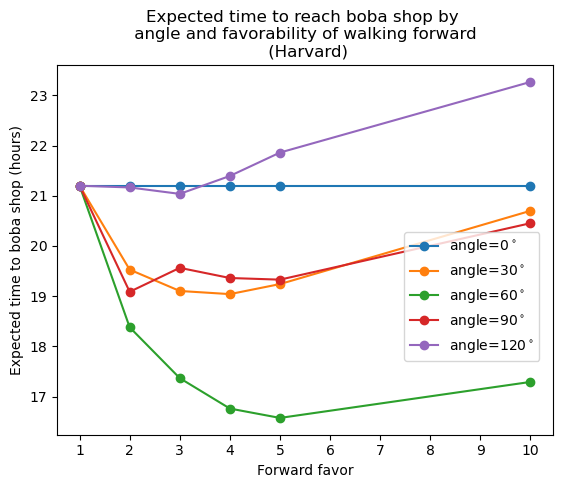

In [114]:
fig, ax = plt.subplots()

for angle in angles:
    plt.plot(favors, results[angles.index(angle)] / 60, "o-", label=fr"angle=${angle:.0f}^\circ$")

# ax.set_xscale("log")
# ax.set_yscale("log")
ax.ticklabel_format(style='plain')

plt.xticks(range(1, 11))
plt.xlabel("Forward favor")
plt.ylabel(f"Expected time to boba shop (hours)")
plt.title("Expected time to reach boba shop by \n angle and favorability of walking forward \n (Harvard)");

# plt.legend(loc="lower right");
plt.legend(loc=(0.7, 0.2));

### "Inefficiency" for Harvard

Compute (expected random walk time) / (shortest time)

In [139]:
slug = "harvard"

In [140]:
G, adj, boba_gdf = get_data(slug)
print(f"Graph has {len(G.nodes()):,} nodes and {len(G.edges()):,} edges.")
nodes = sorted(adj.keys())

Graph has 27,191 nodes and 77,299 edges.


In [182]:
end_nodes = get_end_nodes(G, boba_gdf)
print(f"{len(end_nodes)} end nodes")

259 end nodes


In [147]:
angle, favor = 60, 5
with open(f"./output/avg_time/{slug}.pkl", "rb") as fin:
    E_time = pickle.load(fin)[(angle, favor)]

with open(f"./data/shortest_paths/{slug}.pkl", "rb") as fin:
    shortest_paths = pickle.load(fin)

shortest_paths = np.array([shortest_paths[node] for node in nodes])

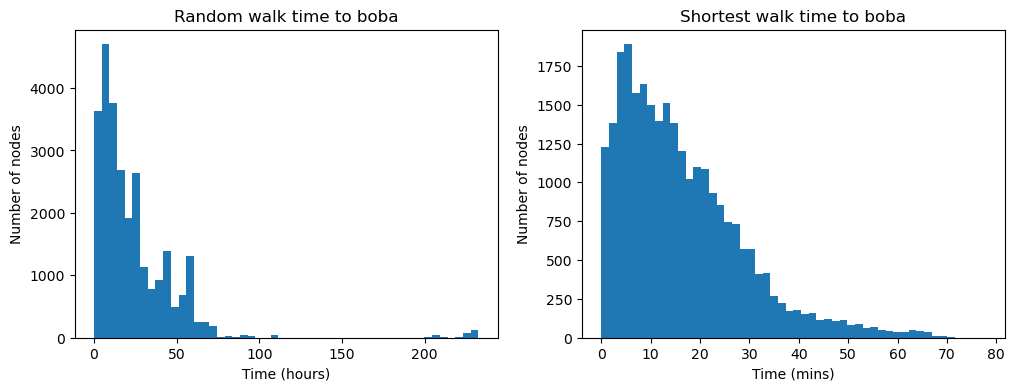

In [212]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plt.axes(axs[0])
plt.xlabel("Time (hours)")
plt.ylabel("Number of nodes")
plt.title("Random walk time to boba")
plt.hist(E_time / 60, bins=50);

plt.axes(axs[1])
plt.xlabel("Time (mins)")
plt.ylabel("Number of nodes")
plt.title("Shortest walk time to boba")
plt.hist(shortest_paths, bins=50);

In [148]:
# Inefficiencies
ineffs = np.divide(E_time, shortest_paths, out=np.zeros_like(E_time), where=(shortest_paths != 0))

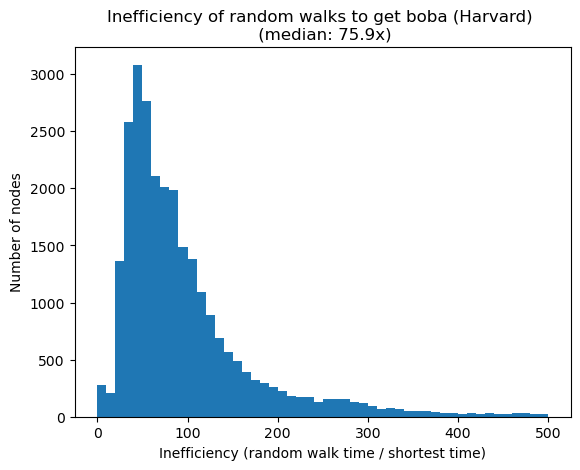

In [211]:
plt.xlabel("Inefficiency (random walk time / shortest time)")
plt.ylabel("Number of nodes")
plt.title(f"Inefficiency of random walks to get boba (Harvard) \n (median: {np.median(ineffs):.1f}x)")
plt.hist(ineffs[ineffs < 500], bins=50);

### Inefficiency analysis across all places

In [205]:
places

[['Harvard', [42.374194, -71.116608], 'harvard'],
 ['MIT', [42.37428, -71.11659], 'mit'],
 ['UW Seattle', [47.65728, -122.30724], 'uw_seattle'],
 ['University of Chicago', [41.7886, -87.59871], 'uchicago'],
 ['Dartmouth College', [43.70444, -72.28869], 'dartmouth'],
 ['Boston University', [42.35049, -71.10539], 'boston_university'],
 ['Princeton University', [40.34309, -74.65507], 'princeton'],
 ['Stanford University', [37.42766, -122.17006], 'stanford'],
 ['Yale University', [41.31632, -72.92234], 'yale'],
 ['Johns Hopkins University', [39.3299, -76.62051], 'johns_hopkins'],
 ['University of Pennsylvania', [39.95221, -75.19321], 'upenn'],
 ['University of California, Los Angeles', [34.06991, -118.4438], 'ucla'],
 ['National Taiwan University',
  [25.01734, 121.53975],
  'national_taiwan_university']]

In [206]:
all_ineffs = []

for i, place in enumerate(places):
    placename, coords, place = place
    print(f"[{i:>2}/{len(places)}] Calculating inefficiency for {placename}...")

    G, adj, boba_gdf = get_data(slug)
    end_nodes = get_end_nodes(G, boba_gdf)

    angle, favor = 60, 5
    with open(f"./output/avg_time/{slug}.pkl", "rb") as fin:
        E_time = pickle.load(fin)[(angle, favor)]
    with open(f"./data/shortest_paths/{slug}.pkl", "rb") as fin:
        shortest_paths = pickle.load(fin)
    shortest_paths = np.array([shortest_paths[node] for node in nodes])

    # Inefficiencies
    ineffs = np.divide(E_time, shortest_paths, out=np.zeros_like(E_time), where=(shortest_paths != 0))
    all_ineffs = np.concatenate([all_ineffs, ineffs])

[ 0/13] Calculating inefficiency for Harvard...
[ 1/13] Calculating inefficiency for MIT...
[ 2/13] Calculating inefficiency for UW Seattle...
[ 3/13] Calculating inefficiency for University of Chicago...
[ 4/13] Calculating inefficiency for Dartmouth College...
[ 5/13] Calculating inefficiency for Boston University...
[ 6/13] Calculating inefficiency for Princeton University...
[ 7/13] Calculating inefficiency for Stanford University...
[ 8/13] Calculating inefficiency for Yale University...
[ 9/13] Calculating inefficiency for Johns Hopkins University...
[10/13] Calculating inefficiency for University of Pennsylvania...
[11/13] Calculating inefficiency for University of California, Los Angeles...
[12/13] Calculating inefficiency for National Taiwan University...


In [207]:
with open(f"./output/all_ineffs.pkl", "wb") as fout:
    pickle.dump(all_ineffs, fout)

### Analyze inefficiencies

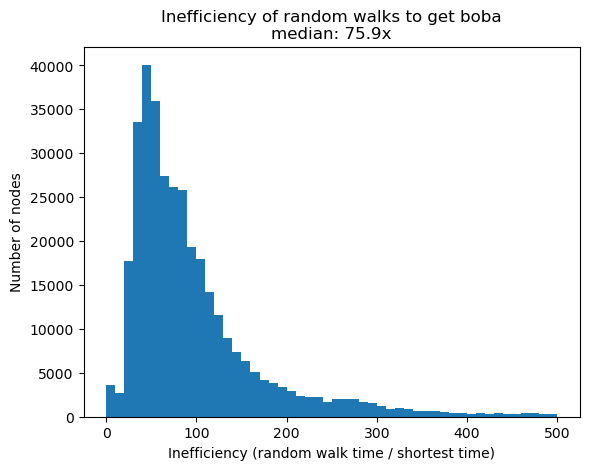

In [216]:
plt.xlabel("Inefficiency (random walk time / shortest time)")
plt.ylabel("Number of nodes")
plt.title(f"Inefficiency of random walks to get boba\nmedian: {np.median(all_ineffs):.1f}x")
plt.hist(all_ineffs[all_ineffs < 500], bins=50);